## Import Libraries

In [2]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

## Load the Data

In [3]:
df = pd.read_csv("../cleaned/clean_data.csv")

In [4]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10754 entries, 0 to 10753
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team                 10754 non-null  object 
 1   name                 10754 non-null  object 
 2   position             10754 non-null  object 
 3   height               10754 non-null  float64
 4   age                  10754 non-null  float64
 5   appearance           10754 non-null  int64  
 6   goals                10754 non-null  float64
 7   assists              10754 non-null  float64
 8   yellow cards         10754 non-null  float64
 9   second yellow cards  10754 non-null  float64
 10  red cards            10754 non-null  float64
 11  goals conceded       10754 non-null  float64
 12  clean sheets         10754 non-null  float64
 13  minutes played       10754 non-null  int64  
 14  days_injured         10754 non-null  int64  
 15  games_injured        10754 non-null 

In [5]:
df.head(2)

,team,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,0.0,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

<p style="color:blue">We have already conducted the EDA in EDA NoteBook</p>

In [6]:
df[df.duplicated()]

,team,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [7]:
df.dtypes

team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [8]:
df.drop("name", axis=1, inplace=True)

# select features columns
categorical_features = list(df.select_dtypes(object).columns)
numeric_features = list(df.select_dtypes('number'))

# remove encoded columns
numeric_features.remove('position_encoded')
numeric_features.remove('winger')

# removing this increased the r2 score but idk of this is luck (need more checking)
# numeric_features.remove("highest_value")

# remove true value column
numeric_features.remove("current_value")

print(categorical_features)
print(numeric_features)

['team', 'position']
['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets', 'minutes played', 'days_injured', 'games_injured', 'award', 'highest_value']


In [9]:
for i in categorical_features:
    print (df[i].value_counts())

team
Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 12
Gaziantep FK               6
Name: count, Length: 374, dtype: int64
position
Defender Centre-Back          1821
Attack Centre-Forward         1353
Goalkeeper                    1229
midfield-CentralMidfield      1149
midfield-DefensiveMidfield     900
Defender Right-Back            867
Defender Left-Back             807
midfield-AttackingMidfield     769
Attack-RightWinger             717
Attack-LeftWinger              714
midfield-RightMidfield         102
midfield-LeftMidfield          100
midfield                        75
Attack-SecondStriker            65
Attack                          53
Defender                        33
Name: count, dtype: int64


In [10]:
for i in numeric_features:
    print (df[i].value_counts())

height
180.000000    744
185.000000    608
175.000000    596
178.000000    594
183.000000    572
188.000000    493
184.000000    458
182.000000    449
181.240353    440
186.000000    423
187.000000    419
176.000000    390
177.000000    372
190.000000    371
173.000000    366
179.000000    359
181.000000    355
170.000000    312
191.000000    272
174.000000    270
189.000000    255
172.000000    254
192.000000    203
193.000000    181
171.000000    169
168.000000    124
194.000000    117
169.000000    107
195.000000     98
167.000000     85
196.000000     68
166.000000     44
165.000000     42
197.000000     31
198.000000     24
163.000000     16
160.000000     15
164.000000     14
199.000000     12
200.000000     12
202.000000      6
162.000000      6
161.000000      3
206.000000      2
204.000000      1
156.000000      1
159.000000      1
Name: count, dtype: int64
age
22.000000    841
23.000000    823
26.000000    812
25.000000    772
24.000000    767
21.000000    715
28.000000    67

In [11]:
# all good for categorical data

In [12]:
# from our EDA we know that we have too many normal outliers


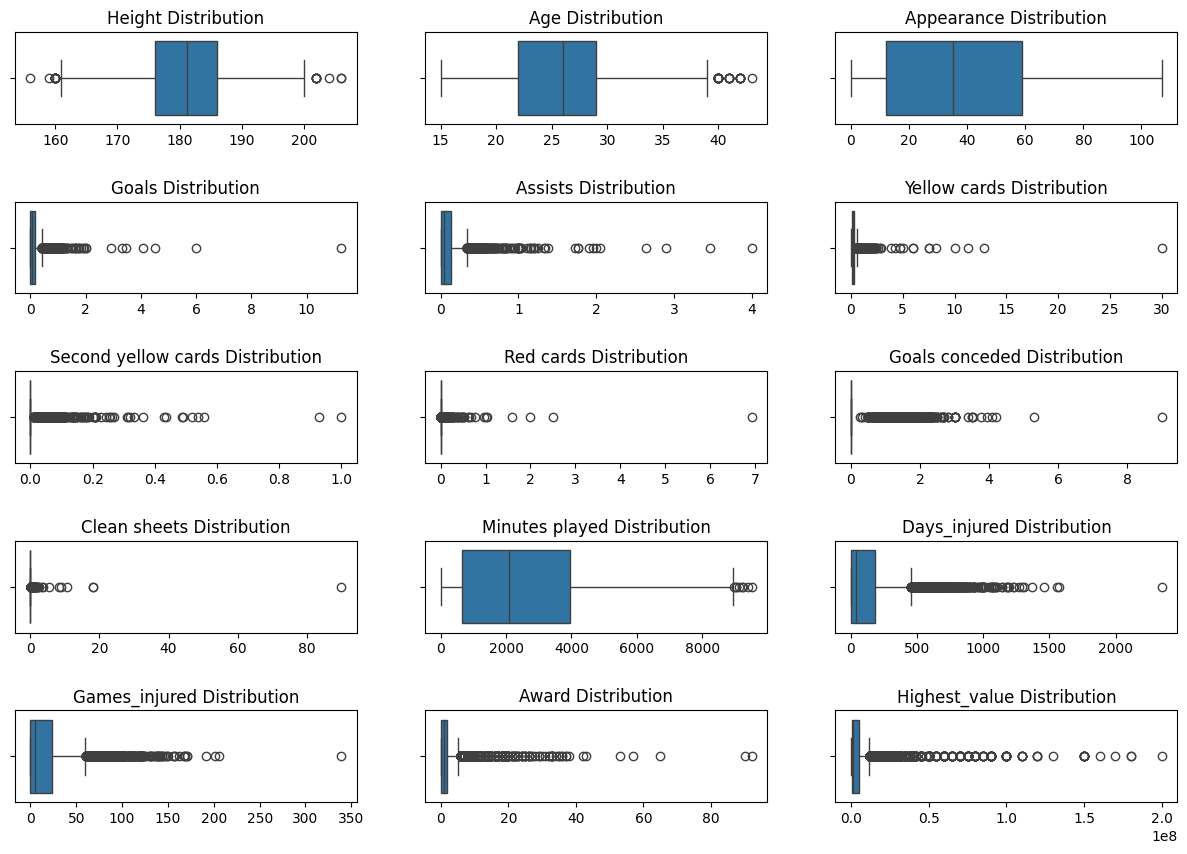

In [13]:
def plot_outliers(df: pd.DataFrame, features: list[str]) -> None:
    """
    Plots boxplots to show outliers for specified features in a DataFrame.
    
    param df: pd.DataFrame
    param features: list[str]
    
    return: None
    """
    # determine the number of rows needed for subplots
    n_rows: int = (len(features) + 2) // 3
    
    # create figure for subplots
    plt.figure(figsize=(15, 10))
    
    # plot each feature as a boxplot to show outliers
    for i, column in enumerate(features, 1):
        # add subplot
        plt.subplot(n_rows, 3, i)
        
        # create boxplot
        sns.boxplot(x=df[column])
        
        # set plot title and labels
        plt.title(f'{column.capitalize()} Distribution')
        plt.xlabel('')
        
        # add space between plots for clarity
        plt.subplots_adjust(hspace=0.85)
    
    # show plots
    plt.show()
    
plot_outliers(df, numeric_features)

In [14]:
# here we can see that there is many outliers and in our case 
# the Linear Regression is sensitive to outliers so we need a way to deal with the outlier, here are some:
# Z-Score
# IQR
# we will be using IQR

In [15]:
def remove_outliers_iqr(data: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    Removes outliers from specified columns in a DataFrame using the IQR method.
    
    param data: pd.DataFrame
    param columns: list[str]
    
    return: pd.DataFrame
    """
    # iterate over each column to remove outliers
    for column in columns:
        # calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        
        # calculate IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        # define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # filter out outliers
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    return data

In [16]:
def remove_outliers_zscore(df: pd.DataFrame, columns: list[str], threshold: float = 3.0) -> pd.DataFrame:
    """
    Removes outliers from specified columns in a DataFrame using the Z-score method.
    
    param df: pd.DataFrame - The input data.
    param columns: list[str] - The list of columns to check for outliers.
    param threshold: float - The Z-score threshold for identifying outliers.
    
    return: pd.DataFrame - The DataFrame with outliers removed.
    """
    # calculate Z-scores
    z_scores = np.abs(df[columns].apply(zscore))

    # filter out outliers
    filtered_df = df[(z_scores < threshold).all(axis=1)]
    
    return filtered_df

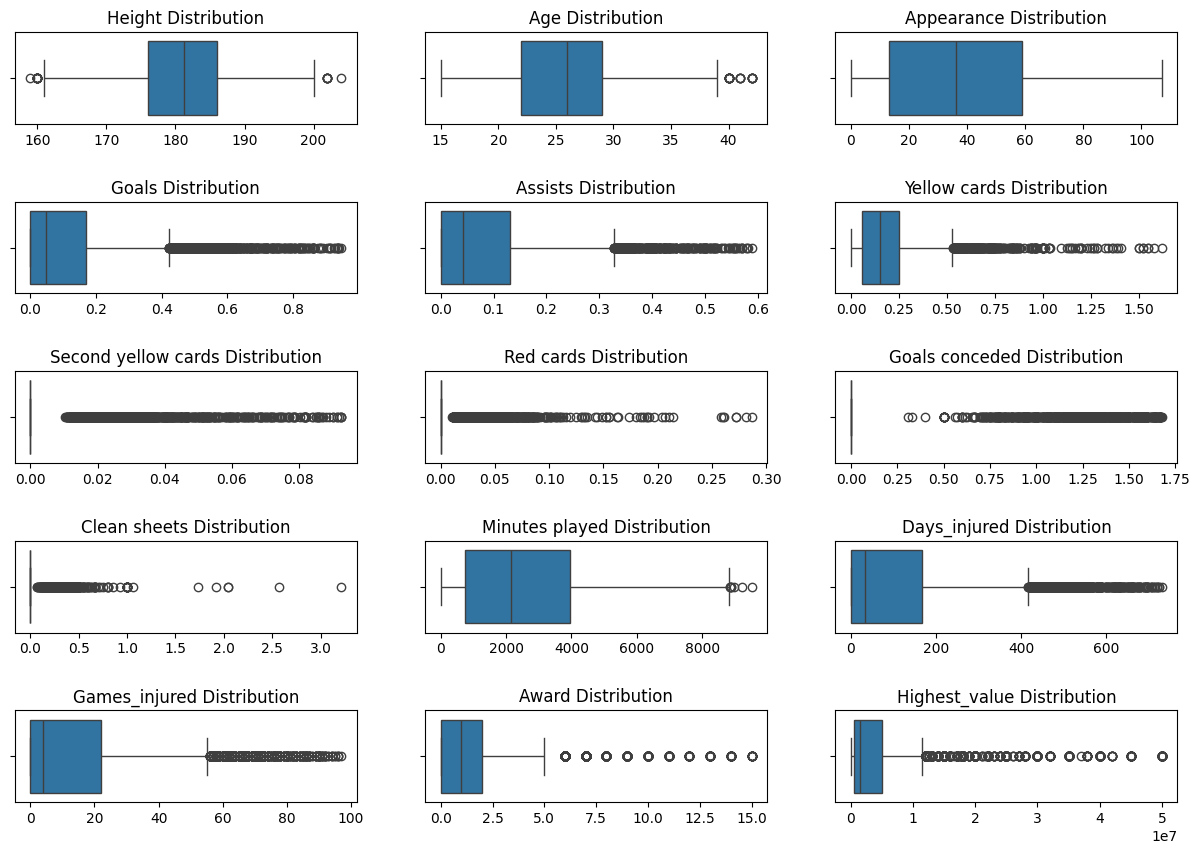

Original vs IQR: (10754, 20) vs (9850, 20) 


In [17]:
# filter outlier
filtered_data = remove_outliers_zscore(df, numeric_features, 3.5)

# plot to compare
plot_outliers(filtered_data, numeric_features)
print(f"Original vs IQR: {df.shape} vs {filtered_data.shape} ")

In [18]:
# here we can see that the outliers are better by visualization (some data are too small need check)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [19]:
# here we just change the df
df = filtered_data.copy()

In [20]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
1,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
2,Manchester United,Goalkeeper,188.0,37.0,4,0.0,0.0,0.000000,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000,1,0


In [21]:
categorical_features

['team', 'position']

In [22]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [23]:
display(df.head(2))
df.shape

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
1,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,...,False,False,False,True,False,False,False,False,False,False
2,188.0,37.0,4,0.0,0.0,0.000000,0.0,0.0,0.616438,0.924658,...,False,False,False,True,False,False,False,False,False,False


(9850, 408)

#### 3. Feature selection

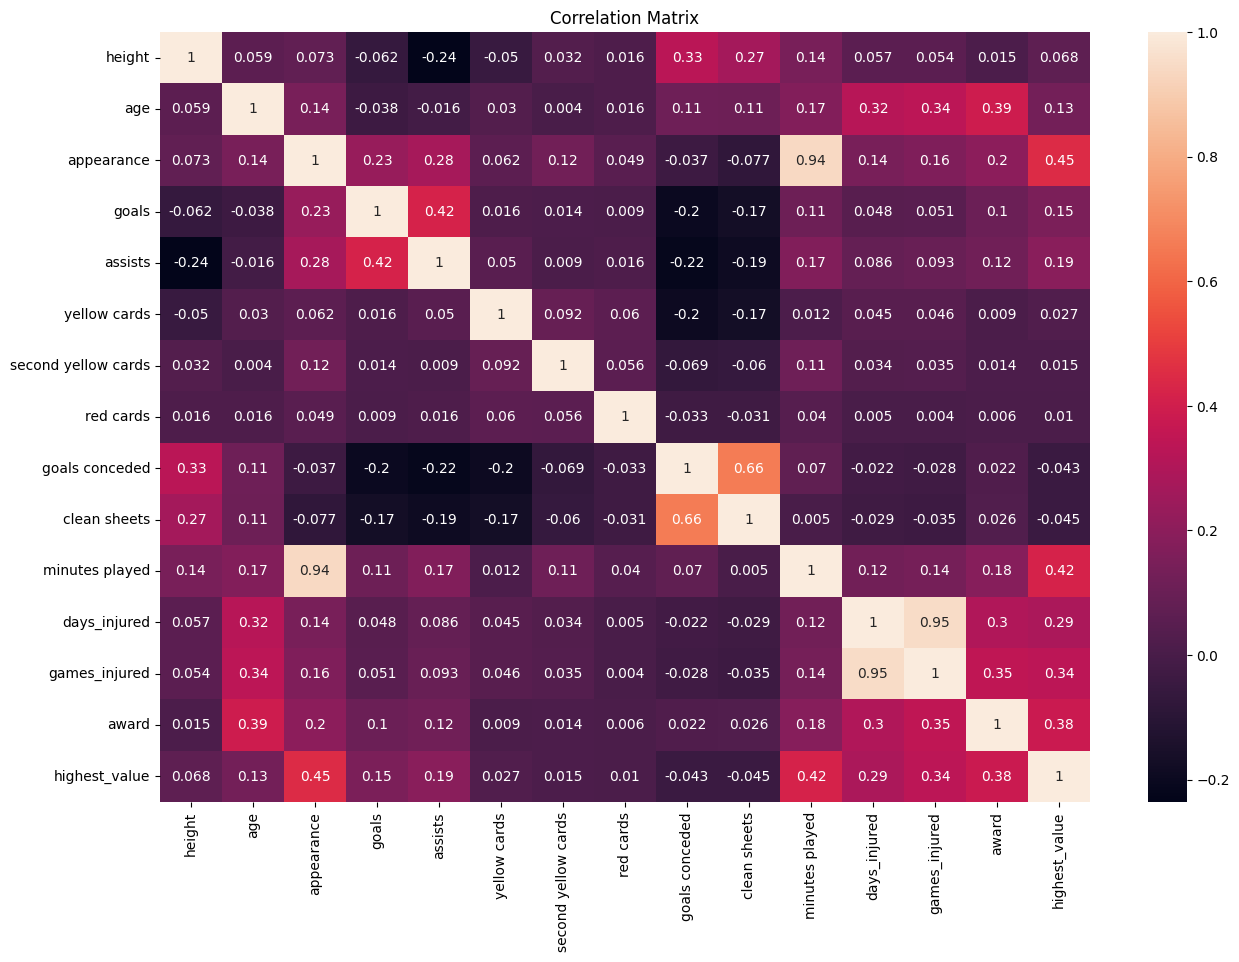

In [24]:
plt.figure(figsize=(15, 10))
sns.heatmap(round(df[numeric_features].corr(),3), annot=True)
plt.title('Correlation Matrix')
plt.show()

In [25]:
correlation = df.corr()
print(correlation['current_value'].sort_values(ascending=False).head(10))

current_value       1.000000
highest_value       0.837734
appearance          0.449071
minutes played      0.441575
award               0.213919
assists             0.178278
team_Arsenal FC     0.174372
games_injured       0.158427
goals               0.150073
team_Aston Villa    0.135839
Name: current_value, dtype: float64


In [26]:
# Set the correlation threshold
threshold = 0.05  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value']) > threshold]['current_value'].index
selected_features

Index(['height', 'age', 'appearance', 'goals', 'assists', 'minutes played',
       'days_injured', 'games_injured', 'award', 'current_value',
       'highest_value', 'position_encoded', 'team_AC Milan',
       'team_ACF Fiorentina', 'team_AFC Bournemouth', 'team_AS Monaco',
       'team_AS Roma', 'team_Ajax Amsterdam', 'team_Arsenal FC',
       'team_Aston Villa', 'team_Atalanta BC', 'team_Athletic Bilbao',
       'team_Atlético de Madrid', 'team_Bayer 04 Leverkusen',
       'team_Bayern Munich', 'team_Borussia Dortmund',
       'team_Borussia Mönchengladbach', 'team_Brentford FC',
       'team_Brighton &amp; Hove Albion', 'team_Chelsea FC',
       'team_Crystal Palace', 'team_Everton FC', 'team_FC Barcelona',
       'team_FC Porto', 'team_Fulham FC', 'team_Inter Milan',
       'team_Juventus FC', 'team_Leeds United', 'team_Leicester City',
       'team_Liverpool FC', 'team_Manchester City', 'team_Manchester United',
       'team_Newcastle United', 'team_Nottingham Forest',
       'tea

In [27]:
df[selected_features]

,height,age,appearance,goals,assists,minutes played,days_injured,games_injured,award,current_value,...,team_Real Sociedad,team_SL Benfica,team_SSC Napoli,team_Southampton FC,team_Stade Rennais FC,team_Tottenham Hotspur,team_Villarreal CF,team_West Ham United,team_Wolverhampton Wanderers,position_Goalkeeper
1,196.000000,30.0,15,0.000000,0.000000,1304,510,58,1,1500000,...,False,False,False,False,False,False,False,False,False,True
2,188.000000,37.0,4,0.000000,0.000000,292,697,84,4,600000,...,False,False,False,False,False,False,False,False,False,True
3,175.000000,25.0,82,0.028090,0.056180,6408,175,22,9,50000000,...,False,False,False,False,False,False,False,False,False,False
6,187.000000,28.0,70,0.000000,0.032901,5471,95,19,10,15000000,...,False,False,False,False,False,False,False,False,False,False
8,186.000000,21.0,34,0.000000,0.000000,2758,47,13,0,2000000,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10749,181.240353,20.0,16,0.175953,0.087977,1023,0,0,0,75000,...,False,False,False,False,False,False,False,False,False,False
10750,190.000000,24.0,26,0.372671,0.186335,1449,102,18,0,300000,...,False,False,False,False,False,False,False,False,False,False
10751,181.240353,19.0,20,0.375000,0.000000,960,0,0,0,50000,...,False,False,False,False,False,False,False,False,False,False
10752,181.240353,20.0,17,0.312139,0.104046,865,0,0,0,50000,...,False,False,False,False,False,False,False,False,False,False


#### 4. Prepare train and test data

In [30]:
list(df.columns)

['height',
 'age',
 'appearance',
 'goals',
 'assists',
 'yellow cards',
 'second yellow cards',
 'red cards',
 'goals conceded',
 'clean sheets',
 'minutes played',
 'days_injured',
 'games_injured',
 'award',
 'current_value',
 'highest_value',
 'position_encoded',
 'winger',
 'team_1.FC Köln',
 'team_1.FC Union Berlin',
 'team_1.FSV Mainz 05',
 'team_AA Argentinos Juniors',
 'team_AC Ajaccio',
 'team_AC Milan',
 'team_AC Monza',
 'team_ACF Fiorentina',
 'team_AFC Bournemouth',
 'team_AJ Auxerre',
 'team_AS Monaco',
 'team_AS Roma',
 'team_AZ Alkmaar',
 'team_Abha Club',
 'team_Adana Demirspor',
 'team_Adelaide United',
 'team_Ajax Amsterdam',
 'team_Akhmat Grozny',
 'team_Al-Adalah FC',
 'team_Al-Batin FC',
 'team_Al-Fateh SC',
 'team_Al-Fayha FC',
 'team_Al-Hilal Saudi FC',
 'team_Al-Ittihad Club (Jeddah)',
 'team_Al-Khaleej',
 'team_Al-Nassr FC',
 'team_Al-Raed SFC',
 'team_Al-Shabab Club (Riyadh)',
 'team_Al-Taawoun FC',
 'team_Al-Tai',
 'team_Al-Wehda FC',
 'team_Alanyaspor',
 '

In [27]:
# Prepare data
X = df.drop(['current_value'], axis=1)
y = df['current_value']

In [28]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=.2)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Buliding the Model

In [29]:
# create models
model = LinearRegression()
model_lasso  = Ridge()
model_ridge = Lasso()


In [30]:
param_grid = {
    'alpha': list(range(9900, 10100, 30))  # Regularization strength
}
grid_search = GridSearchCV(estimator=model_ridge,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

grid_search_lasso = GridSearchCV(estimator=model_lasso,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)


## Train the Model

In [31]:
# fit the model (train)
model.fit(X_train_scaled, y_train)

LinearRegression()

In [32]:
model_lasso.fit(X_train_scaled, y_train)

Ridge()

In [33]:
model_ridge.fit(X_train_scaled, y_train)

Lasso()

In [34]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [9900, 9930, 9960, 9990, 10020, 10050,
                                   10080]},
             scoring='neg_mean_squared_error', verbose=1)

In [35]:
grid_search_lasso.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [9900, 9930, 9960, 9990, 10020, 10050,
                                   10080]},
             scoring='neg_mean_squared_error', verbose=1)

## Test the Model

In [36]:
y_pred = model.predict(X_test_scaled)

In [37]:
y_pred_ridge = model_lasso.predict(X_test_scaled)

In [38]:
y_pred_lasso = model_lasso.predict(X_test_scaled)


In [39]:
# Best hyperparameter
print("Best parameters found (Ridge): ", grid_search.best_params_)

# Best model
best_ridge = grid_search.best_estimator_

Best parameters found (Ridge):  {'alpha': 9960}


In [40]:
# Best hyperparameter
print("Best parameters found (Lasso): ", grid_search.best_params_)

# Best model
best_ridge = grid_search_lasso.best_estimator_

Best parameters found (Lasso):  {'alpha': 9960}


## Interpretation of the Model

### Model 1

In [41]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
display(coeff_df.sort_values(by="Coefficient", ascending=False))

,Coefficient
position_Attack-RightWinger,7.730194e+18
position_Attack-LeftWinger,7.689029e+18
position_Defender Right-Back,6.271737e+18
position_Defender Left-Back,6.013686e+18
team_Jeonbuk Hyundai Motors,5.322462e+18
...,...
games_injured,-8.034013e+05
age,-9.010790e+05
position_Goalkeeper,-2.766833e+17
position_encoded,-4.093952e+18


In [42]:
print(f"Intercept: \ny = mx + ({model.intercept_})") 

Intercept: 
y = mx + (2895428.0546488296)


### Model 2 (Lasso)

In [43]:
coeff_df = pd.DataFrame(model_lasso.coef_,X.columns,columns=['Coefficient'])
display(coeff_df.sort_values(by="Coefficient", ascending=False))

,Coefficient
highest_value,4.225152e+06
minutes played,1.614873e+06
days_injured,5.177041e+05
team_Arsenal FC,3.946832e+05
team_Manchester City,2.397177e+05
...,...
goals conceded,-2.343594e+05
award,-3.586250e+05
appearance,-4.679502e+05
games_injured,-8.103189e+05


In [44]:
print(f"Intercept: \ny = mx + ({model_lasso.intercept_})") 

Intercept: 
y = mx + (2898995.558375635)


### Model 3 (Ridge)

In [45]:
coeff_df = pd.DataFrame(model_ridge.coef_,X.columns,columns=['Coefficient'])
display(coeff_df.sort_values(by="Coefficient", ascending=False))

,Coefficient
highest_value,4.226500e+06
minutes played,1.618453e+06
days_injured,5.196877e+05
team_Arsenal FC,3.955566e+05
team_Manchester City,2.404609e+05
...,...
goals conceded,-2.346795e+05
award,-3.587241e+05
appearance,-4.721671e+05
games_injured,-8.124755e+05


In [46]:
print(f"Intercept: \ny = mx + ({model_ridge.intercept_})") 

Intercept: 
y = mx + (2898995.558375635)


## Evaluating the Model 

### Model 1

In [47]:
y_base = [y_train.mean()] * len(y_test)

1. Mean Square Error

In [48]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base}')

Mean Squared Error of base model: 40400257732559.22


In [49]:
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error for training: 6735379714064.081
Mean Squared Error for testing: 8723462632514.412


2. Mean Absolute Error

In [50]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')

Mean Absolute  Error of base model: 3442308.9083717694


In [51]:
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 1533633.3954066176
Mean Absolute Error for testing: 1674535.4939500536


3. Root Mean Absolute Error

In [52]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 1855.3460346716377


In [53]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 2595261.01077793
Root Mean Squared Error for testing: 2953550.8515199823


4. R Square

In [54]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 1855.3460346716377


In [55]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 2595261.01077793
Root Mean Squared Error for testing: 2953550.8515199823


In [56]:
r2_train = r2_score(y_train, model.predict(X_train_scaled))
r2_test = r2_score(y_test, model.predict(X_test_scaled))
print(f'R2 Score for training: {r2_train}')
print(f'R2 Score for testing: {r2_test}')

R2 Score for training: 0.7912402022447731
R2 Score for testing: 0.7838541477254268


#### Predictions vs. Real Values

In [57]:
predictions = model.predict(X_test_scaled)
#predictions

In [58]:
Real_Values = np.array(y_test)
#Real_Values

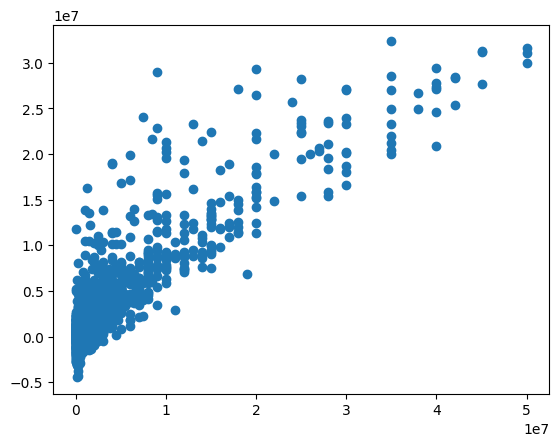

In [59]:
plt.scatter(Real_Values,predictions); 

#### Residual Histogram

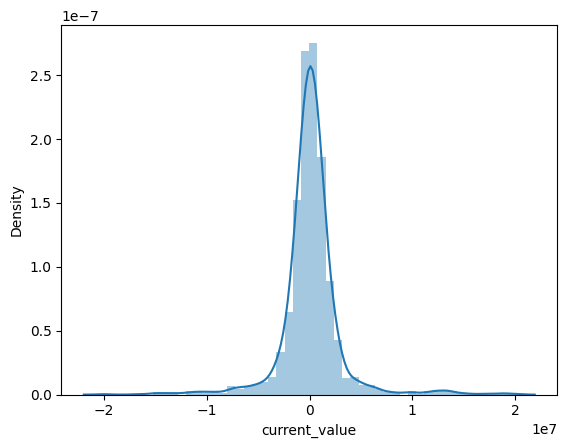

In [60]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

### Model 2 (Lasso)

In [61]:
y_base = [y_train.mean()] * len(y_test)

1. Mean Square Error

In [62]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base}')

Mean Squared Error of base model: 40400257732559.22


In [63]:
mse_train = mean_squared_error(y_train, model_lasso.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error for training: 6723712570125.247
Mean Squared Error for testing: 8723462632514.412


2. Mean Absolute Error

In [64]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')

Mean Absolute  Error of base model: 3442308.9083717694


In [65]:
mae_train = mean_absolute_error(y_train, model_lasso.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 1528140.901627484
Mean Absolute Error for testing: 1674535.4939500536


3. Root Mean Absolute Error

In [66]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 1855.3460346716377


In [67]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 2593012.257997491
Root Mean Squared Error for testing: 2953550.8515199823


4. R Square

In [68]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 1855.3460346716377


In [69]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 2593012.257997491
Root Mean Squared Error for testing: 2953550.8515199823


In [70]:
r2_train = r2_score(y_train, model_lasso.predict(X_train_scaled))
r2_test = r2_score(y_test, model_lasso.predict(X_test_scaled))
print(f'R2 Score for training: {r2_train}')
print(f'R2 Score for testing: {r2_test}')

R2 Score for training: 0.7916018196609325
R2 Score for testing: 0.784397004276513


#### Predictions vs. Real Values

In [71]:
predictions = model_lasso.predict(X_test_scaled)
#predictions

In [72]:
Real_Values = np.array(y_test)
#Real_Values

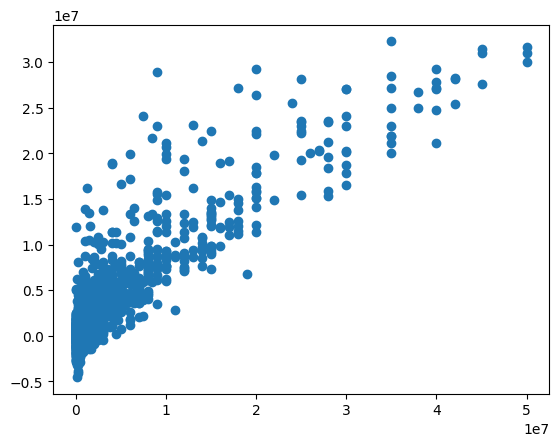

In [73]:
plt.scatter(Real_Values,predictions); 

#### Residual Histogram

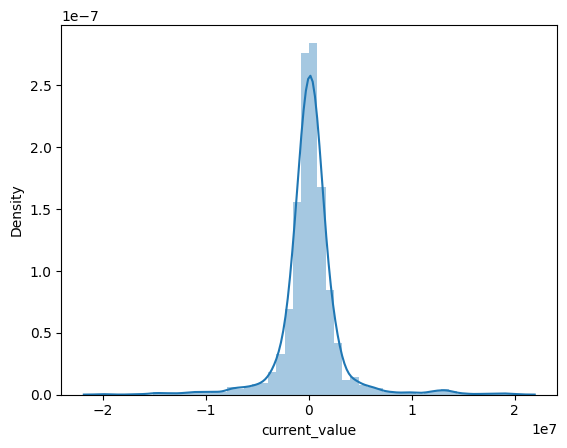

In [74]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

### Model 3 (Ridge)

In [75]:
y_base = [y_train.mean()] * len(y_test)

1. Mean Square Error

In [76]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base}')

Mean Squared Error of base model: 40400257732559.22


In [77]:
mse_train = mean_squared_error(y_train, model_ridge.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error for training: 6723710525891.351
Mean Squared Error for testing: 8723462632514.412


2. Mean Absolute Error

In [78]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')

Mean Absolute  Error of base model: 3442308.9083717694


In [79]:
mae_train = mean_absolute_error(y_train, model_ridge.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 1528264.1495418902
Mean Absolute Error for testing: 1674535.4939500536


3. Root Mean Absolute Error

In [80]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 1855.3460346716377


In [81]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 2593011.863816159
Root Mean Squared Error for testing: 2953550.8515199823


4. R Square

In [82]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 1855.3460346716377


In [83]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 2593011.863816159
Root Mean Squared Error for testing: 2953550.8515199823


In [84]:
r2_train = r2_score(y_train, model_ridge.predict(X_train_scaled))
r2_test = r2_score(y_test, model_ridge.predict(X_test_scaled))
print(f'R2 Score for training: {r2_train}')
print(f'R2 Score for testing: {r2_test}')

R2 Score for training: 0.7916018830209616
R2 Score for testing: 0.7844054429847425


#### Predictions vs. Real Values

In [85]:
predictions = model_ridge.predict(X_test_scaled)
#predictions

In [86]:
Real_Values = np.array(y_test)
#Real_Values

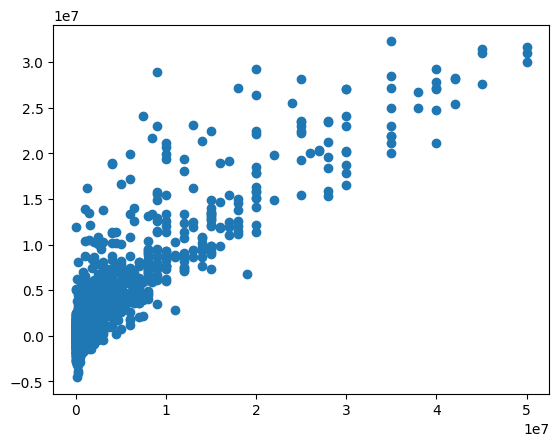

In [87]:
plt.scatter(Real_Values,predictions); 

#### Residual Histogram

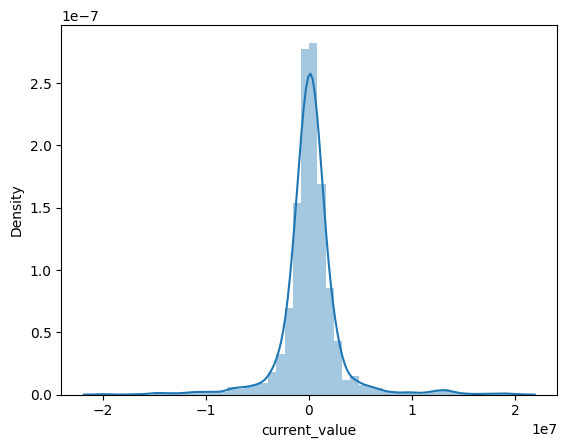

In [88]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution